<a href="https://colab.research.google.com/github/JulesFeo/-/blob/main/ml_mephi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install pymorphy2 nltk

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 25.9 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13704 sha256=99303068664f1f2f4cb9b13d7451913a31bf3467ae4822868d8815821aa767db
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


In [ ]:
pip install sentence-transformers


In [ ]:
pip install transformers torch


In [ ]:
pip install sentence-transformers scikit-learn matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.3/245.3 kB 4.0 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


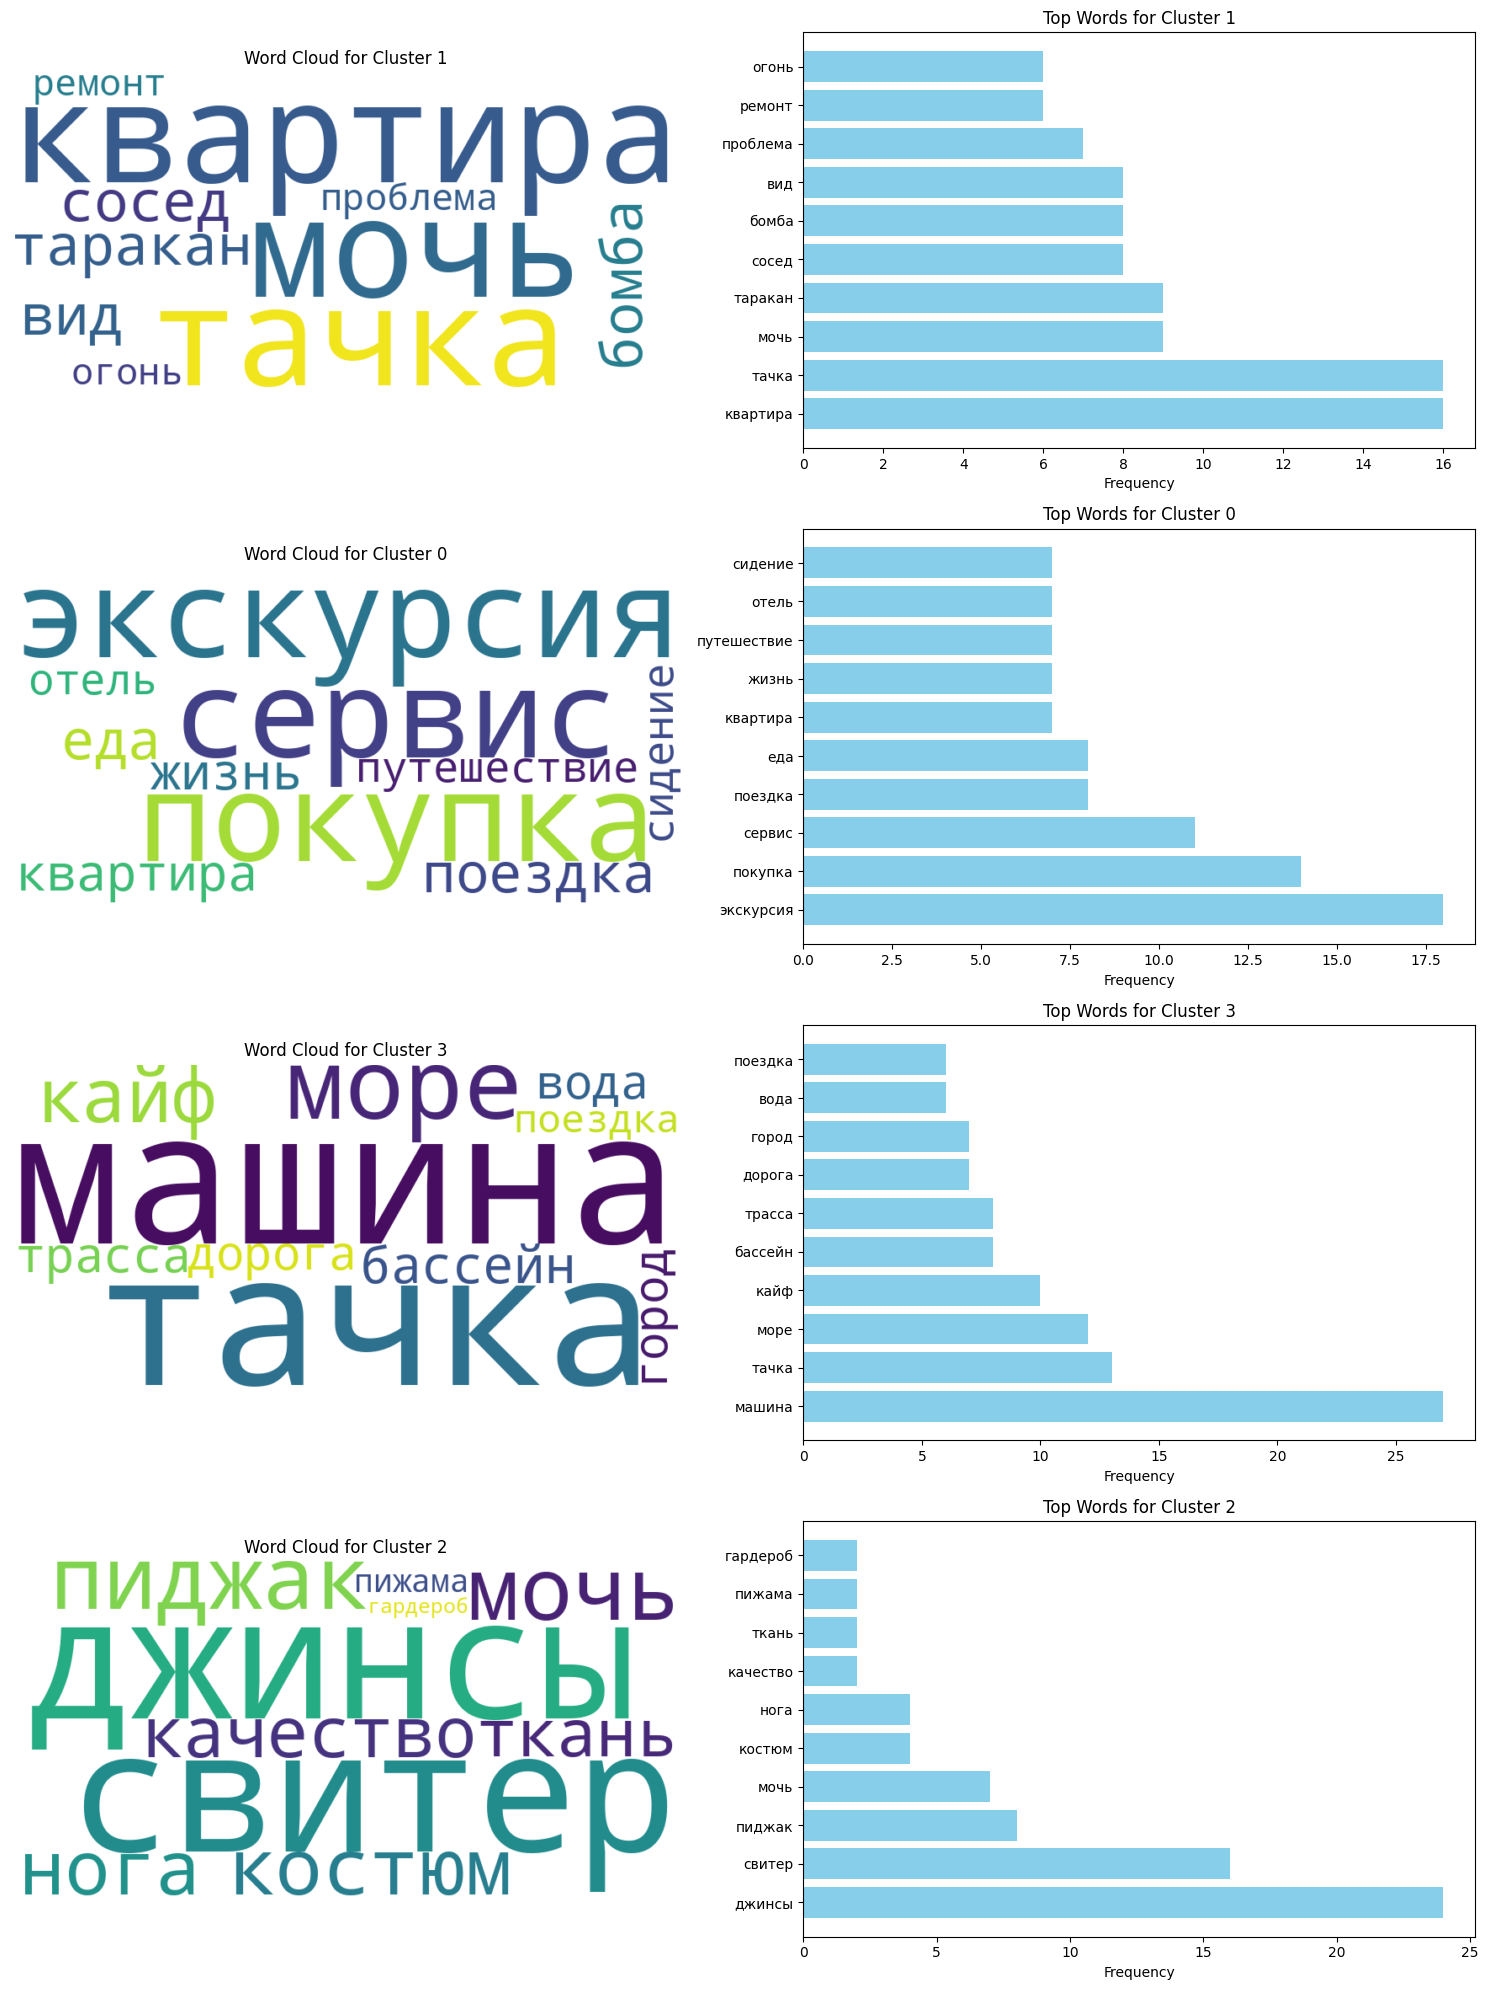

In [ ]:
import csv
import pymorphy2
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
from sentence_transformers import SentenceTransformer
import re
from collections import Counter
from wordcloud import WordCloud  # For generating word clouds

# Загрузка необходимых ресурсов
nltk.download('punkt')
nltk.download('stopwords')

# Инициализация pymorphy2 для лемматизации
morph = pymorphy2.MorphAnalyzer()

# Получаем список стоп-слов для русского языка из NLTK
stop_words = set(stopwords.words('russian')).union({
    "как", "есть", "иногда", "нравится", "это", "а", "и", "в", "на", "что", "с",
    "бы", "чтобы", "да", "нет", "ага", "ну", "во", "по", "всё", "точно", "прикольно",
    "блин", "хрен", "чертов", "зараза", "хрень", "черт", "фига", "фигачи", "срань",
    "что", "что-то", "для", "чё", "во", "чтобы", "чтоб", "?", ",", ".", "!", "1",
    "2", "3", "4", "5", "6", "7", "8", "9", "0"
})

# Удаляем слово "не" из стоп-слов
stop_words.discard("не")

# Функция для очистки текста от знаков препинания и лишних символов
def clean_text(text):
    text = re.sub(r'[\d\W]', ' ', text)  # Удаляем все символы, кроме букв и пробелов
    text = text.lower()  # Приводим к нижнему регистру
    text = re.sub(r'\s+', ' ', text)  # Заменяем несколько пробелов на один
    return text.strip()  # Удаляем пробелы в начале и конце строки

# Функция для лемматизации
def lemmatize(sentence):
    cleaned_sentence = clean_text(sentence)  # Очищаем текст
    tokens = word_tokenize(cleaned_sentence)  # Токенизация
    lemmatized_tokens = []
    for token in tokens:
        token_lower = token.lower()  # Приведение к нижнему регистру
        if token_lower not in stop_words:  # Фильтрация стоп-слов
            parsed_word = morph.parse(token_lower)[0]  # Лемматизация
            normal_form = parsed_word.normal_form
            lemmatized_tokens.append(normal_form)  # Добавляем лемму слова
    return ' '.join(lemmatized_tokens)

# Чтение CSV-файла и лемматизация
def process_csv(file_path):
    processed_sentences = []
    with open(file_path, newline="", encoding='utf-8') as file:
        reader = csv.reader(file)
        next(reader)  # Пропускаем заголовок
        for row in reader:
            sentence = row[0]  # Извлекаем предложение
            processed_sentence = lemmatize(sentence)  # Лемматизируем предложение
            processed_sentences.append(processed_sentence)
    return processed_sentences

# Загрузка модели Sentence Transformers
def get_sentence_embeddings(sentences):
    model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')  # Легковесная модель
    embeddings = model.encode(sentences, convert_to_numpy=True)
    return embeddings

# Функция для кластеризации и вывода результатов с использованием KMeans
def cluster_sentences_kmeans(sentences, n_clusters):
    # Получаем эмбеддинги предложений
    embeddings = get_sentence_embeddings(sentences)

    # Кластеризация методом KMeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=10)
    labels = kmeans.fit_predict(embeddings)

    # Вывод кластеров и создание облаков слов
    generate_wordclouds_and_histograms(sentences, labels)


# Функция для извлечения существительных из предложений
def extract_nouns(sentences):
    nouns = []
    for sentence in sentences:
        tokens = word_tokenize(sentence)
        for token in tokens:
            parsed_word = morph.parse(token)[0]
            if 'NOUN' in parsed_word.tag:  # Проверяем, является ли слово существительным
                nouns.append(parsed_word.normal_form)
    return nouns

# Функция для генерации облаков слов и гистограмм для каждого кластера
def generate_wordclouds_and_histograms(sentences, labels):
    clusters = {}
    for sentence, label in zip(sentences, labels):
        if label not in clusters:
            clusters[label] = []
        clusters[label].append(sentence)

    # Определяем количество кластеров и создаем сетку подграфиков
    num_clusters = len(clusters)
    cols = 2  # Количество колонок для облаков слов и гистограмм
    rows = num_clusters  # Количество строк зависит от количества кластеров
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))  # Размер всей сетки

    # Убираем оси, если кластеров меньше, чем ячеек на графике
    axes = axes.reshape(rows, cols) if num_clusters > 1 else [[axes]]

    # Создание облаков слов и гистограмм для каждого кластера
    for i, (label, cluster_sentences) in enumerate(clusters.items()):
        nouns = extract_nouns(cluster_sentences)  # Извлечение существительных
        top_nouns = Counter(nouns).most_common(10)  # Выбор 10 самых распространенных слов

        # Генерация текста для облака слов
        wordcloud_text = ' '.join([noun for noun, _ in top_nouns])

        # Создание облака слов
        wordcloud = WordCloud(width=800, height=400, background_color="white").generate(wordcloud_text)

        # Отображение облака слов на левом подграфике
        axes[i][0].imshow(wordcloud, interpolation="bilinear")
        axes[i][0].axis("off")
        axes[i][0].set_title(f"Word Cloud for Cluster {label}")

        # Данные для гистограммы
        words, counts = zip(*top_nouns)

        # Создание гистограммы на правом подграфике
        axes[i][1].barh(words, counts, color='skyblue')
        axes[i][1].set_xlabel("Frequency")
        axes[i][1].set_title(f"Top Words for Cluster {label}")

    plt.tight_layout()
    plt.show()

# Путь к файлу CSV
csv_file_path = 'otzivi.csv'

# Обработка предложений
processed_sentences = process_csv(csv_file_path)

# Кластеризация и визуализация с использованием KMeans
cluster_sentences_kmeans(processed_sentences, n_clusters=4)  # Укажите нужное количество кластеров
